<a href="https://colab.research.google.com/github/Balavardhanreddysheelam/RAG-PROJECTS/blob/main/NN_from_scratch_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First importing all the necessary libraries




In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Getting the  data ready

In [40]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [41]:
data = mnist.data
labels = mnist.target

In [42]:
n = np.random.choice(np.arange(data.shape[0]+1))
n


np.int64(13956)

In [43]:
test_img = data.iloc[n].values
test_label = mnist.target.iloc[n]

test_img.shape

(784,)

In [44]:
labels[0]

'5'

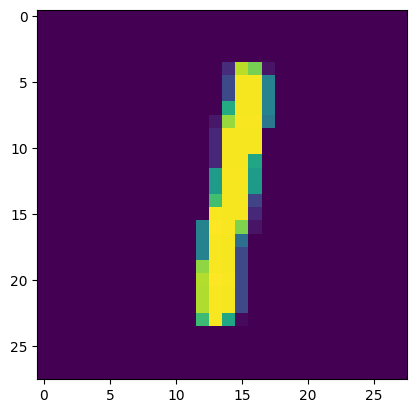

In [45]:
plt.imshow(test_img.reshape(28,28))

setting up the weights along with one hidden layer

In [46]:
w1 = np.ones((784,4))*0.1
z1 = np.dot(data,w1)
z1.shape

w2 = np.ones((4,10))
z2 = np.dot(z1,w2)
z2.shape

(70000, 10)

defining the activation function

In [87]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))
def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)
def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)
def leaky_relu(z: np.ndarray) -> np.ndarray:
    return np.where(z > 0, z, z * 0.01)

used softmax for the output

In [48]:
def softmax(z:np.ndarray) -> np.ndarray:
  return np.exp(z)/np.sum(np.exp(z))


normalizing the vectors intput

In [49]:
def normalize(x: np.ndarray) ->np.ndarray:
  return(x-np.min(x))/(np.max(x)-np.min(x))

hot encoding because labels are in 1d so converting into 2d with multipying with identity matrix

In [50]:
def one_hot_encode(x:np.ndarray,num_labels:int) -> np.ndarray:
  return np.eye(num_labels)[x]


derivatives

In [88]:
def derivative(function_name: str, z: np.ndarray) -> np.ndarray:
    if function_name == "sigmoid":
        return sigmoid(z) * (1 - sigmoid(z))
    if function_name == "tanh":
        return 1 - np.square(tanh(z))
    if function_name == "relu":
        y = (z > 0) * 1
        return y
    if function_name == "leaky_relu":
        return  np.where(z > 0, 1, 0.01)
    return "No such activation"

In [98]:
class NN:
  def __init__(self, X:np.ndarray, y:np.ndarray, X_test:np.ndarray, y_test:np.ndarray, activation:str, num_labels: int, architecture:list[int]):
    self.X = normalize(X)
    self.X_test = normalize(X_test)
    self.y, self.y_test = y.copy(), y_test.copy()
    self.architecture = architecture
    self.activation = activation
    self.num_labels = num_labels
    self.parameters = {}
    self.m = X.shape[1]
    self.architecture.append(self.num_labels)
    self.num_input_features = X.shape[0]
    self.architecture.insert(0, self.num_input_features)
    self.L = len(self.architecture)
    self.layers = {}

    assert self.X.shape == (self.num_input_features, self.m)
    assert self.y.shape == (self.num_labels, self.m)

  def initialize_parameters(self):
    for i in range (1, self.L):
      print(f"Initializing parameters for layer:{i}.")
      self.parameters["w"+str(i)] = np.random.randn(self.architecture[i], self.architecture[i-1]) * 0.01
      self.parameters["b"+str(i)] = np.zeros((self.architecture[i], 1))

  def forward(self):
    params = self.parameters
    self.layers["a0"] = self.X
    for l in range(1, self.L - 1):
      self.layers["z" + str(l)] = np.dot(params["w" + str(l)], self.layers["a" + str(l - 1)]) + params["b" + str(l)]
      self.layers["a" + str(l)] = eval(self.activation)(self.layers["z" + str(l)])
      assert self.layers["a" + str(l)].shape == (self.architecture[l], self.m)

    self.layers["z" + str(self.L - 1)] = np.dot(params["w" + str(self.L - 1)], self.layers["a" + str(self.L - 2)]) + params["b" + str(self.L - 1)]
    self.layers["a" + str(self.L - 1)] = softmax(self.layers["z" + str(self.L - 1)])
    self.output = self.layers["a" + str(self.L - 1)]

    assert self.output.shape == (self.num_labels, self.m)

    cost = - np.sum(self.y * np.log(self.output + 1e-10)) / self.m

    return cost, self.layers

  def backpropagate(self):
    derivatives = {}
    dZ = self.output - self.y
    assert dZ.shape == (self.num_labels, self.m)

    dW = np.dot(dZ, self.layers["a" + str(self.L - 2)].T) / self.m
    db = np.sum(dZ, axis=1, keepdims=True) / self.m
    dAPrev = np.dot(self.parameters["w" + str(self.L - 1)].T, dZ)

    derivatives["dW" + str(self.L - 1)] = dW
    derivatives["db" + str(self.L - 1)] = db

    for l in range(self.L - 2, 0, -1):
      dZ = dAPrev * derivative(self.activation, self.layers["z" + str(l)])
      dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l - 1)].T)
      db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
      if l > 1:
        dAPrev = np.dot(self.parameters["w" + str(l)].T, (dZ))
      derivatives["dW" + str(l)] = dW
      derivatives["db" + str(l)] = db
    self.derivatives = derivatives

    return self.derivatives

  def fit(self, lr=0.01, epochs=1000):
    self.costs = []
    self.initialize_parameters()
    self.accuracies = {"train": [], "test": []}
    for epoch in tqdm(range(epochs), colour="BLUE"):
      cost, cache = self.forward()
      self.costs.append(cost)
      derivatives = self.backpropagate()
      for layer in range(1, self.L):
        self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
        self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]
      train_accuracy = self.accuracy(self.X, self.y)
      test_accuracy = self.accuracy(self.X_test, self.y_test)
      if epoch % 10 == 0:
        print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Train Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}")
      self.accuracies["train"].append(train_accuracy)
      self.accuracies["test"].append(test_accuracy)
    print("Training has terminated")

  def predict(self, x):
    params = self.parameters
    n_layers = self.L - 1
    values = [x]
    for l in range(1, n_layers):
      z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
      a = eval(self.activation)(z)
      values.append(a)
    z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
    a = softmax(z)

    if x.shape[1] > 1:
      ans = np.argmax(a, axis=0)
    else:
      ans = np.argmax(a)
    return ans

  def accuracy(self, X, y):
    P = self.predict(X)
    return np.mean(np.equal(P, np.argmax(y, axis=0))) * 100

In [72]:
NN

__main__.NN

In [91]:
def intialize_parameters(self):
  for i in range (1,self.l):
    print(f"Initializing parameters for layer:{i}.")
    self.parameters["w"+str(i)] = np.random.randn(self.architecture[i],self.architecture[i-1])*0.01
    self.parameters["b"+str(i)] = np.zeros(self.architecture[i],1)

FEEDFORWAD

In [90]:
def forward(self):
        params=self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L-1):
            self.layers["z" + str(l)] = np.dot(params["w" + str(l)],
                                               self.layers["a"+str(l-1)]) + params["b"+str(l)]
            self.layers["a" + str(l)] = eval(self.activation)(self.layers["z"+str(l)])
            assert self.layers["a"+str(l)].shape == (self.architecture[l], self.m)
        self.layers["z" + str(self.L-1)] = np.dot(params["w" + str(self.L-1)],
                                                  self.layers["a"+str(self.L-2)]) + params["b"+str(self.L-1)]
        self.layers["a"+str(self.L-1)] = softmax(self.layers["z"+str(self.L-1)])
        self.output = self.layers["a"+str(self.L-1)]
        assert self.output.shape == (self.num_labels, self.m)
        assert all([s for s in np.sum(self.output, axis=1)])

        cost = - np.sum(self.y * np.log(self.output + 0.000000001))

        return cost, self.layers

BACKPROPAGATION

In [92]:
def backpropagate(self):
        derivatives = {}
        dZ = self.output - self.y
        assert dZ.shape == (self.num_labels, self.m)
        dW = np.dot(dZ, self.layers["a" + str(self.L-2)].T) / self.m
        db = np.sum(dZ, axis=1, keepdims=True) / self.m
        dAPrev = np.dot(self.parameters["w" + str(self.L-1)].T, dZ)
        derivatives["dW" + str(self.L-1)] = dW
        derivatives["db" + str(self.L-1)] = db

        for l in range(self.L-2, 0, -1):
            dZ = dAPrev * derivative(self.activation, self.layers["z" + str(l)])
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l-1)].T)
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = np.dot(self.parameters["w" + str(l)].T, (dZ))
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
        self.derivatives = derivatives

        return self.derivatives

Fitting, accuracy, and predictions

In [93]:
def fit(self, lr=0.01, epochs=1000):
        self.costs = []
        self.initialize_parameters()
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, cache = self.forward()
            self.costs.append(cost)
            derivatives = self.backpropagate()
            for layer in range(1, self.L):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")

In [94]:
def predict(self, x):
        params = self.parameters
        n_layers = self.L - 1
        values = [x]
        for l in range(1, n_layers):
            z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
            a = eval(self.activation)(z)
            values.append(a)
        z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
        a = softmax(z)
        if x.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        return ans


def accuracy(self, X, y):
    P = self.predict(X)
    return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100

In [85]:
train_test_split_no = 60000
X_train = data.values[:train_test_split_no].T
y_train = labels[:train_test_split_no].values.astype(int)
y_train = one_hot_encode(y_train, 10).T
X_test = data.values[train_test_split_no:].T
y_test = labels[train_test_split_no:].values.astype(int)
y_test = one_hot_encode(y_test, 10).T
X_train.shape, X_test.shape
((784, 60000), (784, 10000))

((784, 60000), (784, 10000))

In [100]:
PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [128, 32]]
nn_relu = NN(*PARAMS)
epochs_relu = 80
lr_relu = 0.003
nn_relu.fit(lr=lr_relu, epochs=epochs_relu) # Removed X_train, y_train arguments
# nn_relu.plot_cost(lr_relu) # Commented out as plot_cost method is not defined in the class

Initializing parameters for layer:1.
Initializing parameters for layer:2.
Initializing parameters for layer:3.


  1%|▏         | 1/80 [00:01<02:15,  1.71s/it]

Epoch:   0 | Cost: 13.305 | Train Accuracy: 12.650 | Test Accuracy: 12.560


 14%|█▍        | 11/80 [00:21<02:11,  1.91s/it]

Epoch:  10 | Cost: 13.305 | Train Accuracy: 12.945 | Test Accuracy: 12.930


 26%|██▋       | 21/80 [00:39<01:42,  1.74s/it]

Epoch:  20 | Cost: 13.305 | Train Accuracy: 11.893 | Test Accuracy: 11.850


 39%|███▉      | 31/80 [00:59<01:41,  2.07s/it]

Epoch:  30 | Cost: 13.305 | Train Accuracy: 11.340 | Test Accuracy: 11.380


 51%|█████▏    | 41/80 [01:17<01:10,  1.80s/it]

Epoch:  40 | Cost: 13.305 | Train Accuracy: 11.245 | Test Accuracy: 11.350


 64%|██████▍   | 51/80 [01:35<00:49,  1.70s/it]

Epoch:  50 | Cost: 13.305 | Train Accuracy: 11.237 | Test Accuracy: 11.350


 76%|███████▋  | 61/80 [01:54<00:36,  1.93s/it]

Epoch:  60 | Cost: 13.305 | Train Accuracy: 11.237 | Test Accuracy: 11.350


 89%|████████▉ | 71/80 [02:13<00:16,  1.81s/it]

Epoch:  70 | Cost: 13.305 | Train Accuracy: 11.237 | Test Accuracy: 11.350


100%|██████████| 80/80 [02:30<00:00,  1.88s/it]

Training terminated
